## Player Session Insights

Author: Muhammad Shayan

In [7]:
# Import Libraries
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc, to_timestamp, year
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from geopy.geocoders import Nominatim
import geopandas

### Load Data

In [5]:
# Load data into dataframe for querying
dataPath = "data/playerSessionsData.jsonl.bz2"
playerSessionsDF = spark.read.json(dataPath)
print("The schema of the JSON data is as follows:\n")
playerSessionsDF.printSchema()

playerSessionsDF.registerTempTable("playerSessions")

The schema of the JSON data is as follows:

root
 |-- country: string (nullable = true)
 |-- event: string (nullable = true)
 |-- player_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- ts: string (nullable = true)



### Number of sessions total 

In [14]:
# Get number of unique session ids
uniqueSessions = spark.sql("SELECT DISTINCT session_id FROM playerSessions")
numSessions = uniqueSessions.count()
print('The total number of sessions in the dataset are: %d' % numSessions)

The total number of sessions in the dataset are: 500587


### Number of completed sessions

In [15]:
# Get list of sessions that started
startSessions = spark.sql("SELECT DISTINCT session_id, player_id, country, ts FROM playerSessions WHERE event = 'start'")
startedSessions = startSessions.count()
print('The number of started sessions are: %d' % startedSessions)

# Get list of sessions that ended
endSessions = spark.sql("SELECT DISTINCT session_id FROM playerSessions WHERE event = 'end'")
endedSessions = endSessions.count()
print('The number of ended sessions are: %d' % endedSessions)

#Merge/Join
completedSessions = startSessions.join(endSessions, how='inner', on=['session_id'])
numCompletedSessions = completedSessions.count()
print('The number of completed sessions are: %d' % (numCompletedSessions))

The number of started sessions are: 500584
The number of ended sessions are: 500585
The number of completed sessions are: 500582


### Sessions completed per country

In [16]:
# Group completed sessions by country. Sort descending and print
countryCount = completedSessions.groupBy('country').count()
countryCountSort = countryCount.sort("count", ascending=False)
countryCountSort.show(countryCountSort.count(), truncate=False)

+-------+-----+
|country|count|
+-------+-----+
|IT     |2839 |
|SH     |2672 |
|AZ     |2670 |
|AT     |2655 |
|WF     |2616 |
|VA     |2602 |
|HU     |2584 |
|IL     |2563 |
|RO     |2550 |
|KR     |2535 |
|SR     |2533 |
|TO     |2521 |
|MD     |2516 |
|LS     |2475 |
|NO     |2461 |
|DE     |2440 |
|TF     |2433 |
|EG     |2431 |
|CD     |2423 |
|GS     |2414 |
|BV     |2408 |
|LA     |2402 |
|MQ     |2372 |
|NA     |2370 |
|MA     |2365 |
|MN     |2365 |
|CR     |2362 |
|MO     |2356 |
|FI     |2349 |
|BR     |2342 |
|EH     |2342 |
|SN     |2338 |
|RU     |2336 |
|PF     |2324 |
|TN     |2318 |
|CH     |2310 |
|BO     |2310 |
|JM     |2308 |
|YE     |2296 |
|NI     |2290 |
|DJ     |2284 |
|IR     |2284 |
|TV     |2281 |
|MX     |2277 |
|LT     |2276 |
|SA     |2274 |
|PY     |2272 |
|SY     |2260 |
|GU     |2256 |
|BT     |2248 |
|NL     |2247 |
|BS     |2239 |
|SO     |2231 |
|BN     |2230 |
|CK     |2229 |
|BE     |2222 |
|TL     |2214 |
|HT     |2213 |
|MW     |2212 |
|IE     

### Sessions completed per player

In [17]:
### Completed 
playerIdCount = completedSessions.groupBy('player_id').count()
playerIdCount = playerIdCount.orderBy("count", ascending=False)
playerIdCount.show(playerIdCount.count(), truncate=False)

+--------------------------------+-----+
|player_id                       |count|
+--------------------------------+-----+
|78e64bcc68cf45118f39fa71b24a1a80|50   |
|e903ade03d7644229473e8273ef785a9|50   |
|e348055ce4244e21ad045500b89ef37a|50   |
|ec8cd0f7569840e4b6ba7a36611e1be7|50   |
|2e49966c6fe944989f9a06a25e61baf4|50   |
|814e7c61c7794cb7a9eb0df80239f50b|50   |
|e5c0b7c4c20f45de9b93044cb8e527cb|50   |
|cd451b3999e14f96890f64b1f99a6cde|50   |
|c65cee083d3c4e759e9148de2a12dc6d|50   |
|57cae262ac1d4ac690dbb73e3b581478|50   |
|fdae77dd943947ea8f5b7970c17baf3c|50   |
|504c38fb47224c3ab600a85ae8271bf1|50   |
|01d1f31c3c864538a6a5f3cb238d0072|50   |
|d0da3eada549446a94aea743ae58db21|50   |
|7c87f73c61d14a5c8bd0a74608413356|50   |
|27a68ba22bc9427289987e4d340fd0ef|50   |
|5cdc9d0ec9d047c38cc92b699d6a1262|50   |
|90da81415994463b8baa49c93de80458|50   |
|255e898c6e71491f9f1b65bd72b47951|50   |
|d8448bb448594f59a3f4d1bb23ccebe4|50   |
|68cd425a98294388b144562ea8facec8|50   |
|3e3fd2b6b5354a8

### Country with most started sessions during 2018

In [18]:
startTimeStamp = startSessions.withColumn("timestamp_year", year(to_timestamp(startSessions.ts)))
start2018Sessions = startTimeStamp.filter('timestamp_year=2018')
numSessions = start2018Sessions.count()
print("Number of sessions started in 2018:%d" % numSessions)
print("There are no countries with a session started in 2018")

Number of sessions started in 2018:0
There are no countries with a session started in 2018


### Plot completed player sessions by country

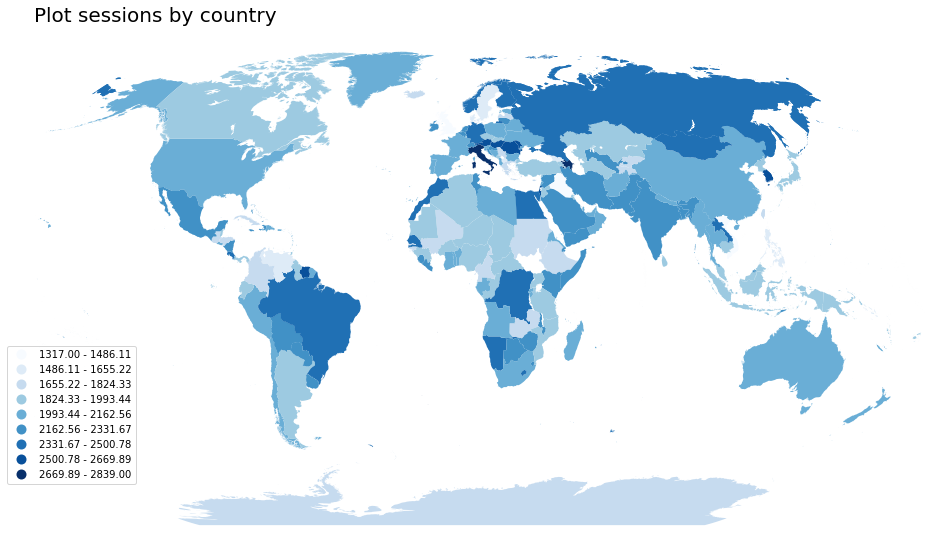

In [30]:
import geopandas

colors = 9
cmap = 'Blues'
figsize = (16, 10)
shapefile = 'data_countries/ne_10m_admin_0_countries_lakes.shp'
title = "Plot sessions by country"

pdCountryCount = countryCount.toPandas()
country_data = pd.read_csv('countries_codes_and_coordinates.csv')

country_data = country_data[['Alpha-2 code', 'Alpha-3 code']]
country_data = country_data.rename(columns={'Alpha-2 code': 'country', 'Alpha-3 code': 'ADM0_A3'})
                                   
country_data = country_data.applymap(lambda x: x.replace('"', ''))
country_data = country_data.applymap(lambda x: x.replace(' ', ''))

countryDataLatLong = pd.merge(pdCountryCount, country_data, on='country', how='inner')
countryDataLatLong = countryDataLatLong.dropna()

print(countryDataLatLong.head())

shape_file = geopandas.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
merged = shape_file.merge(countryDataLatLong, on='ADM0_A3', how='outer')

ax = merged.dropna().plot('count', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)

ax.set_title(title, fontdict={'fontsize': 20}, loc='left')

ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))